## IP based grouping

In [1]:
import pandas as pd
import ipaddress
import numpy as np

from analyzer import _FLOW_FIELDS

In [2]:
df_orig = pd.read_csv("data.csv", names=_FLOW_FIELDS, parse_dates=['ts'])

In [11]:
df_orig.head()

,ts,ip_protocol,state,src_ip,src_port,dst_ip,dst_port,src_tx,dst_tx
0,2017-01-27 16:24:42,tcp,closed,10.2.1.39,60707,74.201.65.31,443,21687,8999
1,2017-01-27 16:24:42,tcp,closed,10.2.1.39,60708,74.201.65.31,443,37065,14484
2,2017-01-27 16:24:42,tcp,closed,192.168.111.106,38190,10.2.1.38,443,124834,47898
3,2017-01-27 16:24:42,tcp,closed,192.168.111.46,44178,10.2.1.39,443,0,31
4,2017-01-27 16:24:42,tcp,established,10.2.20.1,60246,10.12.0.31,80,20125,1422804


### features
Sample every 1 sec to get ~4200 time samples
- num_conns
- num_flows
- X time_conn = time_first - time_last
- bytes_up, bytes_dw
- X Bps_up, Bps_dw
- udp_flows/udp_conns
- tcp_flows/tcp_conns
- num_ports
- max_port (by number of connection entries)
- conns_max_port
- bytes_max_port_up
- bytes_max_port_dw
- cidr_src_ip, cidr_dst_ip -> to string -> categorize
- pvt_src_ip, pvt_dst_ip

In [23]:
grouped = df_orig.set_index('ts').groupby(['src_ip', 'dst_ip']).resample('10S')

In [35]:
df = grouped['src_tx'].sum().to_frame()

In [36]:
df['bytes_dw'] = grouped['dst_tx'].sum()
df = df.rename(columns={'src_tx':'bytes_dw'})

In [37]:
df['num_conns'] = grouped['src_port'].count()

In [45]:
df['num_flows'] = grouped[['dst_port','src_port', 'ip_protocol']].agg(lambda x: len(set(x))).max(axis=1)

In [59]:
df_orig[(df_orig['src_ip']=="10.2.1.20") & (df_orig['dst_ip']=="10.12.0.31") &
        (df_orig['ts']<=pd.datetime.fromisoformat("2017-01-27 16:47:20")) & (df_orig['ts']>=pd.datetime.fromisoformat("2017-01-27 16:47:10"))]

,ts,ip_protocol,state,src_ip,src_port,dst_ip,dst_port,src_tx,dst_tx
33359,2017-01-27 16:47:10,tcp,established,10.2.1.20,50275,10.12.0.31,80,803,2567
33570,2017-01-27 16:47:13,tcp,established,10.2.1.20,50275,10.12.0.31,80,176677,662
33766,2017-01-27 16:47:16,tcp,established,10.2.1.20,46813,10.12.0.31,80,740,328
33825,2017-01-27 16:47:17,tcp,established,10.2.1.20,42170,10.12.0.31,80,740,488
33826,2017-01-27 16:47:17,tcp,established,10.2.1.20,49128,10.12.0.31,80,378,164
33827,2017-01-27 16:47:17,tcp,established,10.2.1.20,49726,10.12.0.31,80,4042,199732
33903,2017-01-27 16:47:18,tcp,established,10.2.1.20,50233,10.12.0.31,80,370,164
34049,2017-01-27 16:47:20,tcp,established,10.2.1.20,49129,10.12.0.31,80,756,328
34050,2017-01-27 16:47:20,tcp,established,10.2.1.20,49322,10.12.0.31,80,740,328


In [60]:
df['num_dst_port'] = grouped['dst_port'].agg(lambda x: len(set(x)))
df['num_src_port'] = grouped['src_port'].agg(lambda x: len(set(x)))

In [61]:
from collections import Counter

temp = grouped['ip_protocol'].agg(lambda x: Counter(x))

In [66]:
df['tcp_conns'] = temp.apply(lambda x: x['tcp'] if 'tcp' in x else 0)
df['udp_conns'] = temp.apply(lambda x: x['udp'] if 'udp' in x else 0)

In [85]:
import ipaddress

df2 = df.reset_index()

df2['cidr_src_ip'] = df2['src_ip'].apply(lambda x: str(ipaddress.ip_network(x)))
df2['cidr_dst_ip'] = df2['dst_ip'].apply(lambda x: str(ipaddress.ip_network(x)))
df2['pvt_src_ip'] = df2['src_ip'].apply(lambda x: ipaddress.IPv4Address(x).is_private)
df2['pvt_dst_ip'] = df2['dst_ip'].apply(lambda x: ipaddress.IPv4Address(x).is_private)

In [101]:
# all values are counts, so fillna with zeros
df2 = df2.fillna(0)

In [103]:
df2.to_pickle("df_src_dst_sampled_10s.pkl")

# FEATURES

In [2]:
features = ['bytes_dw', 'bytes_dw', 'num_conns',
       'num_flows', 'num_dst_port', 'num_src_port', 'tcp_conns', 'udp_conns',
       'cidr_src_ip', 'cidr_dst_ip', 'pvt_src_ip', 'pvt_dst_ip']
features_min = ['bytes_dw', 'bytes_dw', 'num_conns',
       'num_flows', 'num_dst_port', 'num_src_port', 'tcp_conns', 'udp_conns']

In [3]:
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import normalize, StandardScaler

In [4]:
df2 = pd.read_pickle("df_src_dst_sampled_10s.pkl")

X = df2.loc[:, features_min].values

## PCA

In [9]:
pca = decomposition.PCA(n_components=6)
#X_centered = X - X.mean(axis=0)

X_std = StandardScaler().fit_transform(X)
pca.fit(X_std)


X_pca = pca.transform(X_std)

print(pca.explained_variance_)
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))

[4.14991042 2.72059359 1.25507818 1.19799594 0.59396742 0.07303072]
1 component: 41.5% of initial variance
2 component: 27.21% of initial variance
3 component: 12.55% of initial variance
4 component: 11.98% of initial variance
5 component: 5.94% of initial variance
6 component: 0.73% of initial variance


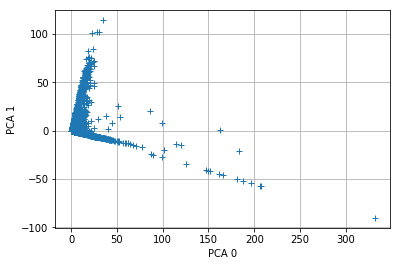

In [6]:
# Plotting the results of PCA
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(X_pca[:, 0], X_pca[:, 1], '+')
ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.grid(1)

## KMEANS

In [7]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [13]:
X_std = StandardScaler().fit_transform(X)

clt = KMeans(n_clusters=8, random_state=0, n_jobs=-1)
model = clt.fit(X_std)
print( model.labels_ )
pred_y = model.fit_predict(X_std)

[6 6 0 ... 0 0 6]


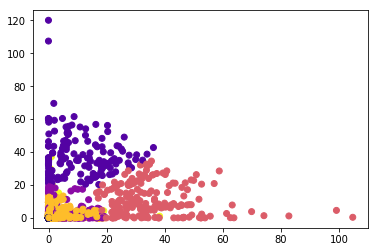

In [14]:
plt.scatter(X_std[:,0], X_std[:,1], c=pred_y, cmap='plasma')
#plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [10]:
distortions = []

for k in range(1,11):
    clt = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    model = clt.fit(X_std)
    print( model.labels_ )
    pred_y = model.fit_predict(X_std)
    
    distortions.append(sum(np.min(cdist(X_std, model.cluster_centers_, 'euclidean'), axis=1)) / X_std.shape[0])


[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[6 6 0 ... 0 0 6]
[0 0 7 ... 7 7 0]
[0 0 7 ... 7 7 0]


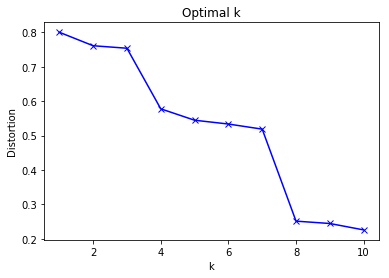

In [12]:
plt.plot(range(1,11), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k')
plt.show()


## DBSCAN

In [7]:
from sklearn.cluster import DBSCAN

In [ ]:
X_std = StandardScaler().fit_transform(X)

clf = DBSCAN(eps=1, min_samples = 2, n_jobs=-1)
model = clf.fit(X_std)
print( model.labels_ )
pred_y = model.fit_predict(X_std)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=pred_y, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## SPECTRAL
- try with rbf due to weird radial view

In [5]:
from sklearn.cluster import SpectralClustering

X_std = StandardScaler().fit_transform(X)

In [ ]:
clf = SpectralClustering(n_clusters = 4, eigen_solver='arpack', affinity='rbf',assign_labels='discretize')
model = clf.fit(X_std)
print(model.labels_)
pred_y = model.fit_predict(X_std)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=pred_y, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
clf = SpectralClustering(n_clusters = 8, eigen_solver='arpack', affinity='rbf',assign_labels='discretize')
model = clf.fit(X_std)
print(model.labels_)
pred_y = model.fit_predict(X_std)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=pred_y, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### TODO: Best port based features


In [69]:
grouped2 = df_orig.set_index('ts').groupby(['src_ip', 'dst_ip', 'src_port']).resample('10S')
df2 = grouped2['src_tx'].sum().to_frame()
df2['bytes_dw'] = grouped2['dst_tx'].sum()
df2 = df2.rename(columns={'src_tx':'bytes_dw'})
df2['num_conns'] = grouped2['src_port'].count()

In [80]:
df2.reset_index().groupby(['src_ip', 'dst_ip', 'src_port', 'ts']).sum()

bytes_dw  bytes_dw  \
src_ip       dst_ip          src_port ts                                        
0.0.0.0      255.255.255.255 68       2017-01-27 16:24:40      3470         0   
                                      2017-01-27 16:24:50         0         0   
                                      2017-01-27 16:25:00         0         0   
                                      2017-01-27 16:25:10         0         0   
                                      2017-01-27 16:25:20         0         0   
                                      2017-01-27 16:25:30         0         0   
                                      2017-01-27 16:25:40         0         0   
                                      2017-01-27 16:25:50         0         0   
                                      2017-01-27 16:26:00         0         0   
                                      2017-01-27 16:26:10         0         0   
                                      2017-01-27 16:26:20         0         0   
                                      2017-01-27 16:26:30         0         0   
                                      2017-01-27 16:26:40      4500         0   
                                      2017-01-27 16:26:50         0         0   
                                      2017-01-27 16:27:00         0         0   
                                      2017-01-27 16:27:10         0         0   
                                      2017-01-27 16:27:20         0         0   
                                      2017-01-27 16:27:30         0         0   
                                      2017-01-27 16:27:40         0         0   
                                      2017-01-27 16:27:50         0         0   
                                      2017-01-27 16:28:00         0         0   
                                      2017-01-27 16:28:10         0         0   
                                      2017-01-27 16:28:20         0         0   
                                      2017-01-27 16:28:30         0         0   
                                      2017-01-27 16:28:40         0         0   
                                      2017-01-27 16:28:50      4153         0   
                                      2017-01-27 16:29:00         0         0   
                                      2017-01-27 16:29:10         0         0   
                                      2017-01-27 16:29:20         0         0   
                                      2017-01-27 16:29:30         0         0   
...                                                             ...       ...   
98.207.16.69 192.168.100.254 64909    2017-01-27 17:28:20         0         0   
                                      2017-01-27 17:28:30         0         0   
                                      2017-01-27 17:28:40         0         0   
                                      2017-01-27 17:28:50     19562     32049   
                                      2017-01-27 17:29:00         0         0   
                                      2017-01-27 17:29:10         0         0   
                                      2017-01-27 17:29:20         0         0   
                                      2017-01-27 17:29:30     37992     40780   
                                      2017-01-27 17:29:40         0         0   
                                      2017-01-27 17:29:50         0         0   
                                      2017-01-27 17:30:00         0         0   
                                      2017-01-27 17:30:10         0         0   
                                      2017-01-27 17:30:20         0         0   
                                      2017-01-27 17:30:30         0         0   
                                      2017-01-27 17:30:40     32873     60707   
                                      2017-01-27 17:30:50         0         0   
                                      2017-01-27 17:31:00         0         0   
         

In [ ]:
grouped3 = df_orig.set_index('ts').groupby(['src_ip', 'dst_ip', 'dst_port']).resample('10S')
df3 = grouped3['src_tx'].sum().to_frame()
df3['bytes_dw'] = grouped3['dst_tx'].sum()
df3 = df3.rename(columns={'src_tx':'bytes_dw'})
df3['num_conns'] = grouped3['src_port'].count()

In [76]:
temp = grouped[['src_port', 'src_tx', 'dst_tx']].agg(lambda x: {x['src_port']:x['src_tx']} )
temp

src_port  \
src_ip       dst_ip          ts                                          
0.0.0.0      255.255.255.255 2017-01-27 16:24:40               {68: 1}   
                             2017-01-27 16:24:50             {5678: 1}   
                             2017-01-27 16:25:00                    {}   
                             2017-01-27 16:25:10                    {}   
                             2017-01-27 16:25:20                    {}   
                             2017-01-27 16:25:30                    {}   
                             2017-01-27 16:25:40                    {}   
                             2017-01-27 16:25:50             {5678: 1}   
                             2017-01-27 16:26:00                    {}   
                             2017-01-27 16:26:10                    {}   
                             2017-01-27 16:26:20                    {}   
                             2017-01-27 16:26:30                    {}   
                             2017-01-27 16:26:40               {68: 1}   
                             2017-01-27 16:26:50             {5678: 1}   
                             2017-01-27 16:27:00                    {}   
                             2017-01-27 16:27:10                    {}   
                             2017-01-27 16:27:20                    {}   
                             2017-01-27 16:27:30                    {}   
                             2017-01-27 16:27:40                    {}   
                             2017-01-27 16:27:50                    {}   
                             2017-01-27 16:28:00                    {}   
                             2017-01-27 16:28:10                    {}   
                             2017-01-27 16:28:20                    {}   
                             2017-01-27 16:28:30                    {}   
                             2017-01-27 16:28:40                    {}   
                             2017-01-27 16:28:50      {68: 1, 5678: 1}   
                             2017-01-27 16:29:00                    {}   
                             2017-01-27 16:29:10                    {}   
                             2017-01-27 16:29:20                    {}   
                             2017-01-27 16:29:30                    {}   
...                                                                ...   
98.207.16.69 192.168.100.254 2017-01-27 17:28:20                    {}   
                             2017-01-27 17:28:30                    {}   
                             2017-01-27 17:28:40                    {}   
                             2017-01-27 17:28:50            {64909: 1}   
                             2017-01-27 17:29:00                    {}   
                             2017-01-27 17:29:10                    {}   
                             2017-01-27 17:29:20                    {}   
                             2017-01-27 17:29:30  {64909: 1, 50341: 1}   
                             2017-01-27 17:29:40                    {}   
                             2017-01-27 17:29:50                    {}   
                             2017-01-27 17:30:00                    {}   
                             2017-01-27 17:30:10            {50341: 1}   
                             2017-01-27 17:30:20                    {}   
                             2017-01-27 17:30:30                    {}   
                             2017-01-27 17:30:40  {64909: 1, 50341: 1}   
                             2017-01-27 17:30:50                    {}   
                             2017-01-27 17:31:00                    {}   
                             2017-01-27 17:31:10                    {}   
                             2017-01-27 17:31:20                    {}   
                             2017-01-27 17:31:30                    {}   
                             2017-01-27 17:31:40                    {}   
                             2017-01-27 17:31:50                  

In [3]:
gp = df_orig.groupby(['src_ip', 'dst_ip'])

In [ ]:
df = gp['state'].count().to_frame().rename(columns={'state':'num_conns'})